In [1]:
from spear.assets import Asset, TaxableAsset
from spear.events import Action, Event
from spear.flows import Expense, TaxableIncome
from spear.model import FinancialModel
import numpy as np

In [ ]:
# One optimization run to determine earliest retirement year given
# some housing cost and interest rate

# Set basic inputs
house_price = Asset(name="House price", initial_value=600_000, growth_rate=0.04)
for y in range(2024, 2100):
    house_price.grow(y)

mortgage_duration = 30
interest_rate = 0.04
initial_house_price = 600_000
fraction_of_debt_free_cases = 0.9
number_of_simulations = 100
simulation_duration = 70

# To store outputs
best_scenario_year_retirement = 10_000
best_scenario_year_house_purchase = 10_000
best_scenario_year_401k_stop = 10_000
best_scenario_year_have_kid = 10_000
saved_planners = dict()

range_year_house_purchase = list(range(2025, 2030))
range_year_have_kid = list(range(2025, 2030))

for year_house_purchase in range_year_house_purchase[::-1]:
    for year_have_kid in range_year_have_kid[::-1]:
        for year_retire in list(range(2025, 2040))[::-1]:
            for year_401k_stop in list(range(2025, year_retire + 1))[::-1]:
                salary = TaxableIncome(name="Salary", initial_value=310_000, state="CA")
                housing = Expense(name="Housing", initial_value=40_000, inflation_rate=0.02)
                cost_of_living = Expense(name="Cost of Living", initial_value=50_000, inflation_rate=0.03)
                health_insurance = Expense(name="Health Insurance", initial_value=0, inflation_rate=0.03)
                mortgage = Expense(name="Mortgage", initial_value=0, inflation_rate=0.0)

                cash = Asset(name="Cash", initial_value=250_000, growth_rate=0.01, cap_value=50_000)
                bonds = TaxableAsset(name="Bonds", initial_value=50_000, growth_rate=0.03, allocation=0.1)
                stocks = TaxableAsset(
                    name="Stocks",
                    initial_value=180_000,
                    growth_rate=0.08,
                    allocation=0.9,
                    sample_growth_rates=True,
                    seed=42
                )
                _401k = Asset(
                    name="401k",
                    initial_value=250_000,
                    growth_rate=0.08,
                    cap_deposit=46_000,
                    pretax=True,
                    sample_growth_rates=True,
                    seed=42
                )

                planner = FinancialModel(
                    revenues=[salary],
                    expenses=[housing, cost_of_living, health_insurance],
                    assets=[cash, bonds, stocks, _401k],
                    events=[get_quit_job_event(year_retire), 
                        get_buy_house_event(year_house_purchase, house_price[year_house_purchase], interest_rate, mortgage_duration), 
                        get_stop_investing_in_401k_event(year_401k_stop),
                        get_have_kid_event(year_have_kid)],
                    duration=simulation_duration,
                    number_of_simulations=number_of_simulations
                    # enable_logging=True,
                )
                planner.run()

                # Count the number of simulations where debt is never positive (i.e. successful early retirement)
                count = np.sum(np.all(planner.debt.base_values <= 0, axis=1))
                count -= 1 # Remove the first row that always returns 0 debt

                if (count / number_of_simulations) >= fraction_of_debt_free_cases:
                    #print("Found case where we will be debt free: ")
                    #print("house purchase year: ", year_house_purchase)
                    #print("retirement year: ",year_retire)
                    #print("401k stop year: ", year_401k_stop)
                    if year_retire <= best_scenario_year_retirement:
                        print("\nFound better scenario:")
                        print("house purchase year: ", year_house_purchase)
                        print("retirement year: ",year_retire)
                        print("401k stop year: ", year_401k_stop)
                        print("house price: ", house_price[year_house_purchase])
                        print("have kid year: ", year_have_kid)
                        best_scenario_year_house_purchase = year_house_purchase
                        best_scenario_year_retirement = year_retire
                        best_scenario_year_401k_stop = year_401k_stop
                        best_scenario_year_have_kid = year_have_kid
                        key_str = str(best_scenario_year_house_purchase) + "-" + \
                        str(best_scenario_year_retirement) + "-" + \
                            str(best_scenario_year_401k_stop) + "-" + \
                            str(best_scenario_year_have_kid)
                        saved_planners[key_str] = planner
                        
print("\nBest scenario:")
print("house purchase year: ", best_scenario_year_house_purchase)
print("retirement year: ",best_scenario_year_retirement)
print("401k stop year: ", best_scenario_year_401k_stop)
print("have kid year: ", best_scenario_year_have_kid)

## Parallelize search over several parameters

In [162]:
import itertools
from typing import Iterator, List, Tuple
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from spear.assets import Asset, PretaxAsset, TaxableAsset
from spear.events import Action, Event
from spear.flows import Expense, TaxableIncome
from spear.model import FinancialModel

# Set basic inputs
MORTGAGE_DURATION = 30
HOUSE_PRICE = 1_000_000

house_prices = Asset(name="House prices", initial_value=HOUSE_PRICE, growth_rate=0.04)
for y in range(2024, 2100):
    house_prices.grow(y)

down_payments = Asset(name="Down payments", initial_value=200_000, growth_rate=0.03)
for y in range(2024, 2100):
    down_payments.grow(y)



In [163]:
def instantiate_revenues() -> List[TaxableIncome]:
    salary = TaxableIncome(name="Salary", initial_value=310_000, state="MA")
    return salary

def instantiate_expenses() -> List[Expense]:
    housing = Expense(name="Housing", initial_value=40_000, inflation_rate=0.02)
    cost_of_living = Expense(name="Cost of Living", initial_value=50_000, inflation_rate=0.03)
    health_insurance = Expense(name="Health Insurance", initial_value=0, inflation_rate=0.03)
    mortgage = Expense(name="Mortgage", initial_value=0, inflation_rate=0.0)
    return housing, cost_of_living, health_insurance, mortgage

def instantiate_assets() -> List[Asset]:
    cash = Asset(name="Cash", initial_value=50_000, growth_rate=0.01, cap_value=50_000)
    bonds = TaxableAsset(name="Bonds", initial_value=190_000, growth_rate=0.03, allocation=0.1)
    stocks = TaxableAsset(
        name="Stocks",
        initial_value=170_000,
        growth_rate=0.08,
        allocation=0.9,
        sample_growth_rates=True,
        seed=42,
    )
    _401k = PretaxAsset(
        name="401k",
        initial_value=280_000, # Includes 120k in 401k and 20k in Roth IRA per person
        growth_rate=0.08,
        cap_deposit=46_000,
        pretax=True,
        sample_growth_rates=True,
        seed=42,
        age=30,
        state="MA",
    )
    return cash, bonds, stocks, _401k

def instantiate_events(
        buy_house_year: int,
        quit_job_year: int,
        have_kid_year: int,
        stop_investing_in_401k_year: int,
        kobold_ipos_year: int,
        mortgage_duration: int,
        salary: TaxableIncome,
        health_insurance: Expense,
        mortgage: Expense,
        cash: Asset,
        bonds: TaxableAsset,
        stocks: TaxableAsset,
        _401k: PretaxAsset,
        housing: Expense,
        cost_of_living: Expense
) -> List[Event]:
    quit_job = Event(
        name="Quit Job",
        year=quit_job_year,
        actions=[
            Action(
                target=salary,
                action="update_base_values",
                params={"new_base_values": 0, "duration": 100},
            ),
            Action(
                target=health_insurance,
                action="update_base_values",
                params={"new_base_values": 6_000, "duration": 100},
            ),
        ],
    )
    house_price = house_prices[buy_house_year]
    down_payment = min(max(0.2 * house_price, down_payments[buy_house_year]), house_price)
    loaned_amount = house_price - down_payment

    def get_monthly_mortgage(loaned_amount: float, interest_rate: float, years: int) -> float:
        n = years * 12
        r = interest_rate / 12
        return loaned_amount * (r * (1 + r) ** n) / ((1 + r) ** n - 1)

    yearly_mortgage = 12 * get_monthly_mortgage(loaned_amount, 0.06, mortgage_duration)

    buy_house = Event(
        name="Buy House",
        year=buy_house_year,
        actions=[
            Action(target=bonds, action="withdraw", params={"amount": down_payment}),
            Action(target=housing, action="update_base_values", params={"new_base_values": 10_000, "duration": 100}),
            Action(target=mortgage, action="update_base_values", params={"new_base_values": yearly_mortgage}),
        ],
    )

    end_mortgage = Event(
        name="End Mortgage",
        year=buy_house_year + mortgage_duration,
        actions=[
            Action(target=mortgage, action="update_base_values", params={"new_base_values": 0, "duration": 100}),
        ],
    )

    have_kid = Event(
        name="Have Kid",
        year=have_kid_year,
        actions=[
            Action(target=cost_of_living, action="add_to_base_values", params={"to_add": 18_200, "duration": 20}),
        ],
    )

    stop_investing_in_401k = Event(
        name="Stop Investing in 401k",
        year=stop_investing_in_401k_year,
        actions=[Action(target=_401k, action="update_cap_deposit", params={"cap_deposit": 0})],
    )

    kobold_ipos = Event(
        name="Kobold Ipos",
        year=kobold_ipos_year,
        actions=[Action(target=salary, action="add_to_base_values", params={"to_add": 900_000})],
    )

    return quit_job, buy_house, end_mortgage, have_kid, stop_investing_in_401k, kobold_ipos


In [164]:
def generate_parameter_combinations(parameters: List[Tuple[int, int]]) -> Iterator[Tuple]:
    """
    Generate all combinations of parameters for ranges generated by start and end.

    Parameters
    ----------
    parameters: List[Tuple[int, int]]
        List of tuples, where each tuple contains the start and end of a range.

    Returns
    -------
    Iterator[Tuple]
        An iterator with all combinations of parameters.
    """
    # Expand each tuple into a range
    expanded_parameters = [range(start, end) for start, end in parameters]
    return itertools.product(*expanded_parameters)

def run_simulation(params: Tuple[int, int, int]) -> Tuple[int, int, int, FinancialModel]:

    buy_house_year, quit_job_year, have_kid_year, stop_investing_in_401k_year, kobold_ipos_year = params

    salary = instantiate_revenues()
    housing, cost_of_living, health_insurance, mortgage = instantiate_expenses()
    cash, bonds, stocks, _401k = instantiate_assets()
    quit_job, buy_house, end_mortgage, have_kid, stop_investing_in_401k, kobold_ipos = instantiate_events(
        buy_house_year=buy_house_year, 
        quit_job_year=quit_job_year, 
        have_kid_year=have_kid_year,
        stop_investing_in_401k_year=stop_investing_in_401k_year,
        kobold_ipos_year=kobold_ipos_year,
        mortgage_duration=MORTGAGE_DURATION,
        salary=salary, 
        health_insurance=health_insurance, 
        mortgage=mortgage,
        cash=cash,
        bonds=bonds,
        stocks=stocks, 
        _401k=_401k,
        housing=housing,
        cost_of_living=cost_of_living
    )

    model = FinancialModel(
        revenues=[salary],
        expenses=[housing, cost_of_living, health_insurance, mortgage],
        assets=[cash, bonds, stocks, _401k],
        events=[quit_job, buy_house, end_mortgage, have_kid, stop_investing_in_401k, kobold_ipos],
        duration=50,
        number_of_simulations=1_000,
    )
    model.run()

    # Count the number of simulations where debt is never positive (i.e. successful early retirement)
    count = np.sum(np.all(model.debt.base_values <= 0, axis=1))
    count -= 1 # Remove the first row that always returns 0 debt
    fraction_of_debt_free_cases = (count / model.number_of_simulations)
    metric = fraction_of_debt_free_cases
    return buy_house_year, quit_job_year, have_kid_year, stop_investing_in_401k_year, kobold_ipos_year, metric, model


In [165]:
buy_house_years = (2025, 2031)
quit_job_years = (2029, 2040)
have_kids_years = (2080, 2081) # Basically not considered
stop_investing_in_401k_years = (2050, 2051) # Basically not considered
kobold_ipos_years = (2080, 2081) # Basically not considered

In [166]:
# Test run_simulation works
run_simulation((2025, 2029, 2028, 2029, 2030))

(2025,
 2029,
 2028,
 2029,
 2030,
 np.float64(-0.001),
 FinancialModel(revenues=[TaxableIncome(name='Salary', initial_value=310000, start_year=2024, duration=100, multiplier=1, number_of_simulations=1000)], expenses=[Expense(name='Housing', initial_value=40000, start_year=2024, duration=100, multiplier=1.02, number_of_simulations=1000), Expense(name='Cost of Living', initial_value=50000, start_year=2024, duration=100, multiplier=1.03, number_of_simulations=1000), Expense(name='Health Insurance', initial_value=0, start_year=2024, duration=100, multiplier=1.03, number_of_simulations=1000), Expense(name='Mortgage', initial_value=0, start_year=2024, duration=100, multiplier=1.0, number_of_simulations=1000)], assets=[Asset(name='Cash', initial_value=50000, start_year=2024, duration=100, multiplier=1.01, number_of_simulations=1000), TaxableAsset(name='Bonds', initial_value=190000, start_year=2024, duration=100, multiplier=1.03, number_of_simulations=1000), TaxableAsset(name='Stocks', initia

In [167]:
parameter_combinations = generate_parameter_combinations([buy_house_years, quit_job_years, have_kids_years, stop_investing_in_401k_years, kobold_ipos_years])
results = Parallel(n_jobs=-1)(delayed(run_simulation)(params) for params in parameter_combinations)

In [168]:
columns = ["buy_house_year", "quit_job_year", "have_kid_year", "stop_investing_in_401k_year", "kobold_ipos_year", "metric", "model"]
results_df = pd.DataFrame(results, columns=columns)
results_df.head()

,buy_house_year,quit_job_year,have_kid_year,stop_investing_in_401k_year,kobold_ipos_year,metric,model
0,2025,2029,2080,2050,2080,-0.001,FinancialModel(revenues=[TaxableIncome(name='S...
1,2025,2030,2080,2050,2080,-0.001,FinancialModel(revenues=[TaxableIncome(name='S...
2,2025,2031,2080,2050,2080,0.001,FinancialModel(revenues=[TaxableIncome(name='S...
3,2025,2032,2080,2050,2080,0.030,FinancialModel(revenues=[TaxableIncome(name='S...
4,2025,2033,2080,2050,2080,0.103,FinancialModel(revenues=[TaxableIncome(name='S...


<Axes: xlabel='quit_job_year', ylabel='buy_house_year'>

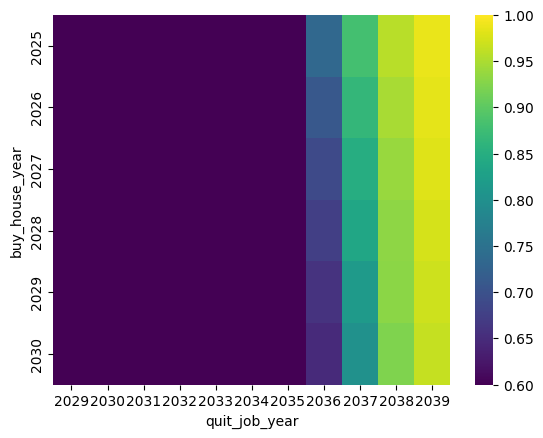

In [169]:
import seaborn as sns

sns.heatmap(results_df.pivot(index="buy_house_year", columns="quit_job_year", values="metric"), cmap="viridis", vmin=0.6, vmax=1)


In [120]:
# buy house year from 2031-2032 and quit job year from 2031-2032
planners_to_view = results_df.query("buy_house_year >= 2025 and buy_house_year <= 2035 and \
                                    quit_job_year >= 2030 and quit_job_year <= 2033")
planners_to_view

,buy_house_year,quit_job_year,have_kid_year,stop_investing_in_401k_year,kobold_ipos_year,metric,model
3,2025,2030,2080,2050,2080,0.651,FinancialModel(revenues=[TaxableIncome(name='S...
4,2025,2031,2080,2050,2080,0.887,FinancialModel(revenues=[TaxableIncome(name='S...
5,2025,2032,2080,2050,2080,0.977,FinancialModel(revenues=[TaxableIncome(name='S...
6,2025,2033,2080,2050,2080,0.996,FinancialModel(revenues=[TaxableIncome(name='S...
13,2026,2030,2080,2050,2080,0.613,FinancialModel(revenues=[TaxableIncome(name='S...
14,2026,2031,2080,2050,2080,0.857,FinancialModel(revenues=[TaxableIncome(name='S...
15,2026,2032,2080,2050,2080,0.964,FinancialModel(revenues=[TaxableIncome(name='S...
16,2026,2033,2080,2050,2080,0.995,FinancialModel(revenues=[TaxableIncome(name='S...
23,2027,2030,2080,2050,2080,0.571,FinancialModel(revenues=[TaxableIncome(name='S...
24,2027,2031,2080,2050,2080,0.835,FinancialModel(revenues=[TaxableIncome(name='S...


In [121]:
#planners_to_view.iloc[0].model.get_expense("Cost of Living").plot(duration=80)
#planners_to_view.iloc[0].model.get_expense("Mortgage").plot(duration=80)

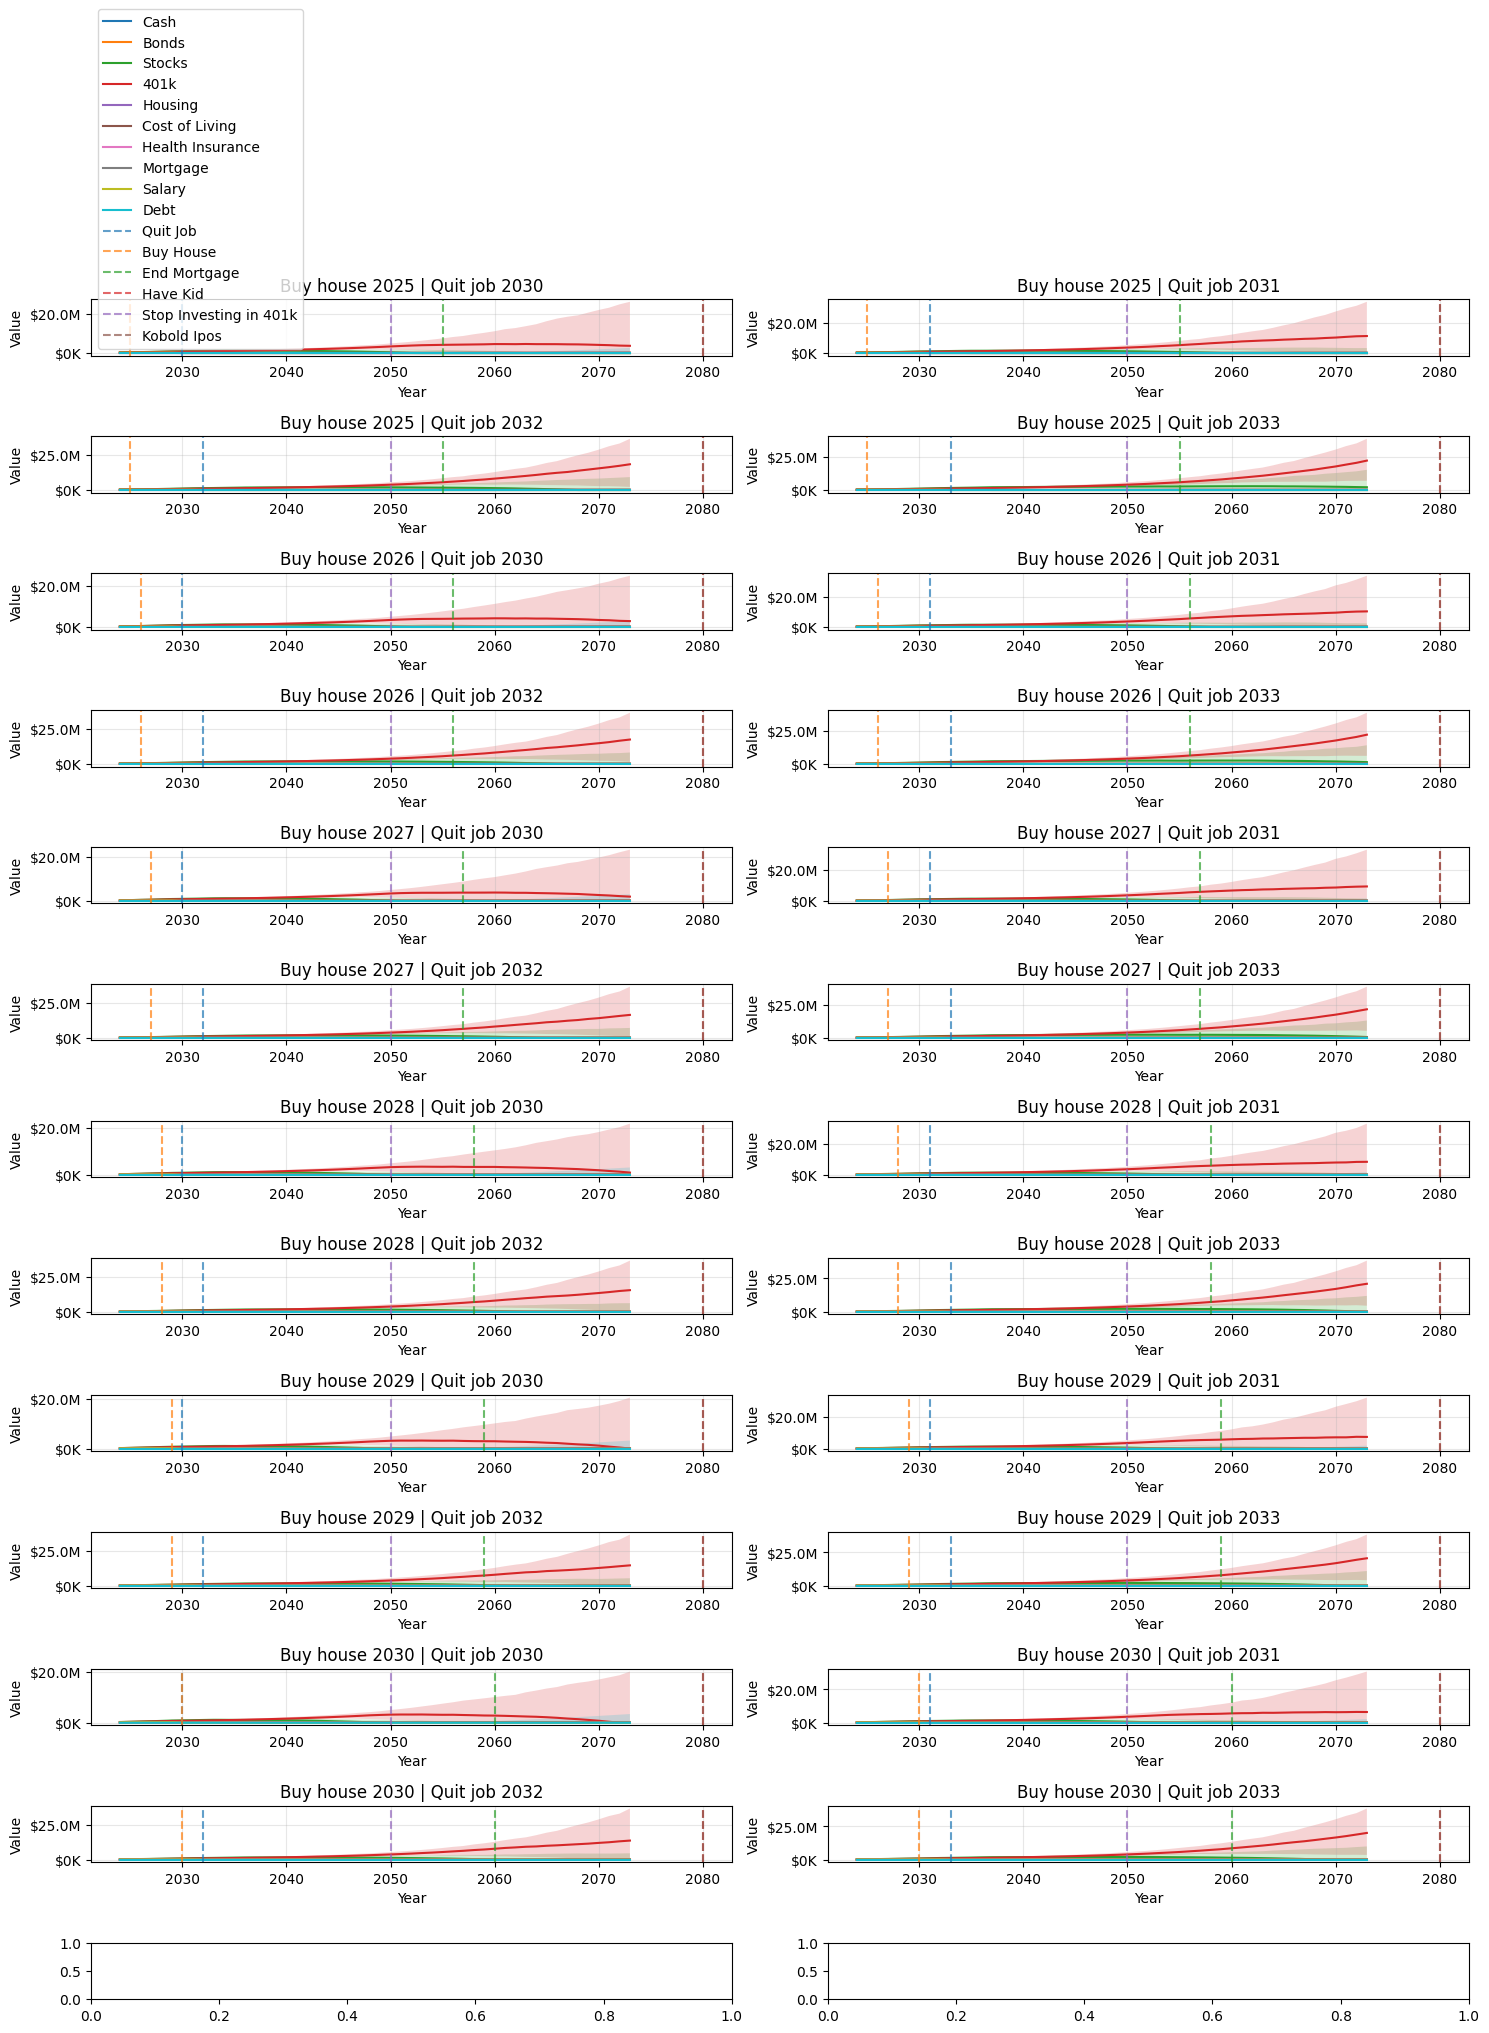

In [123]:
from matplotlib import pyplot as plt

# Order of years in dictionary key: house purchase, retirement, 401k stop
fig, axes = plt.subplots(len(planners_to_view)//2 + 1, 2, figsize=(15,20))
for ax, (_, p) in zip(axes.ravel(), planners_to_view.iterrows()):
    ax = p.model.plot_all(ax);
    ax.set_title(f"Buy house {p['buy_house_year']} | Quit job {p['quit_job_year']}")

# Show legend only for the first graph
for i, ax in enumerate(axes.ravel()):
    if i == 0:
        ax.legend()
    else:
        try:
            ax.get_legend().remove()
        except:
            pass

plt.tight_layout()

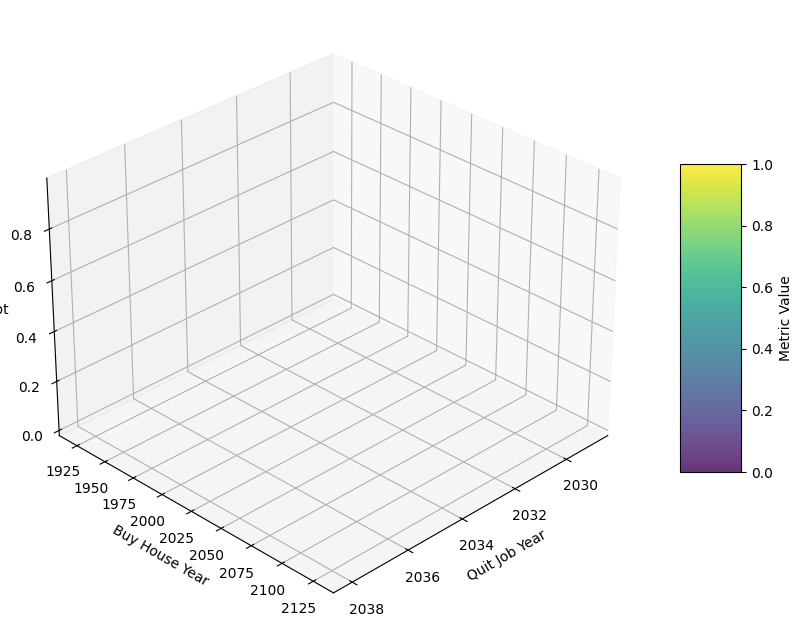

In [161]:
import matplotlib.pyplot as plt
import numpy as np

# Create a pivot table
pivot_df = results_df.pivot_table(values='metric', 
                                  index='buy_house_year', 
                                  columns='quit_job_year', 
                                  )

# Create a meshgrid for the x and y axes
X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, pivot_df.values, cmap='viridis', 
                       rstride=1, cstride=1, antialiased=False, alpha=0.8)

# Set labels and title
ax.set_xlabel('Quit Job Year')
ax.set_ylabel('Buy House Year')
ax.set_zlabel('Debt')

# Add a color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Metric Value')

# Improve the angle for better visibility
ax.view_init(elev=30, azim=45)

In [162]:
# Get the row with index 323
row_323 = results_df.iloc[323]

# Display the row
print(row_323)


IndexError: single positional indexer is out-of-bounds

<Axes: xlabel='Year', ylabel='Value'>

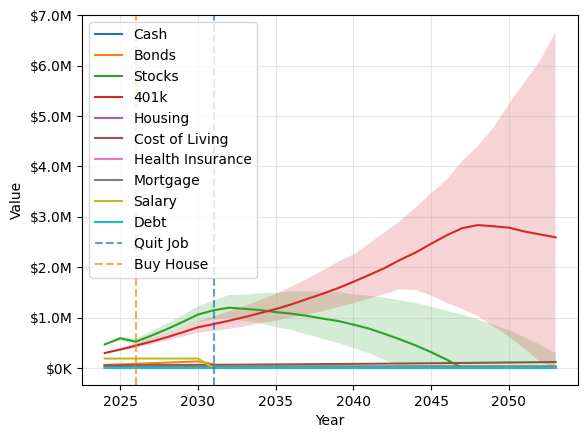

In [ ]:
model = results_df.query("quit_job_year == 2031").iloc[0].model
model.plot_all()


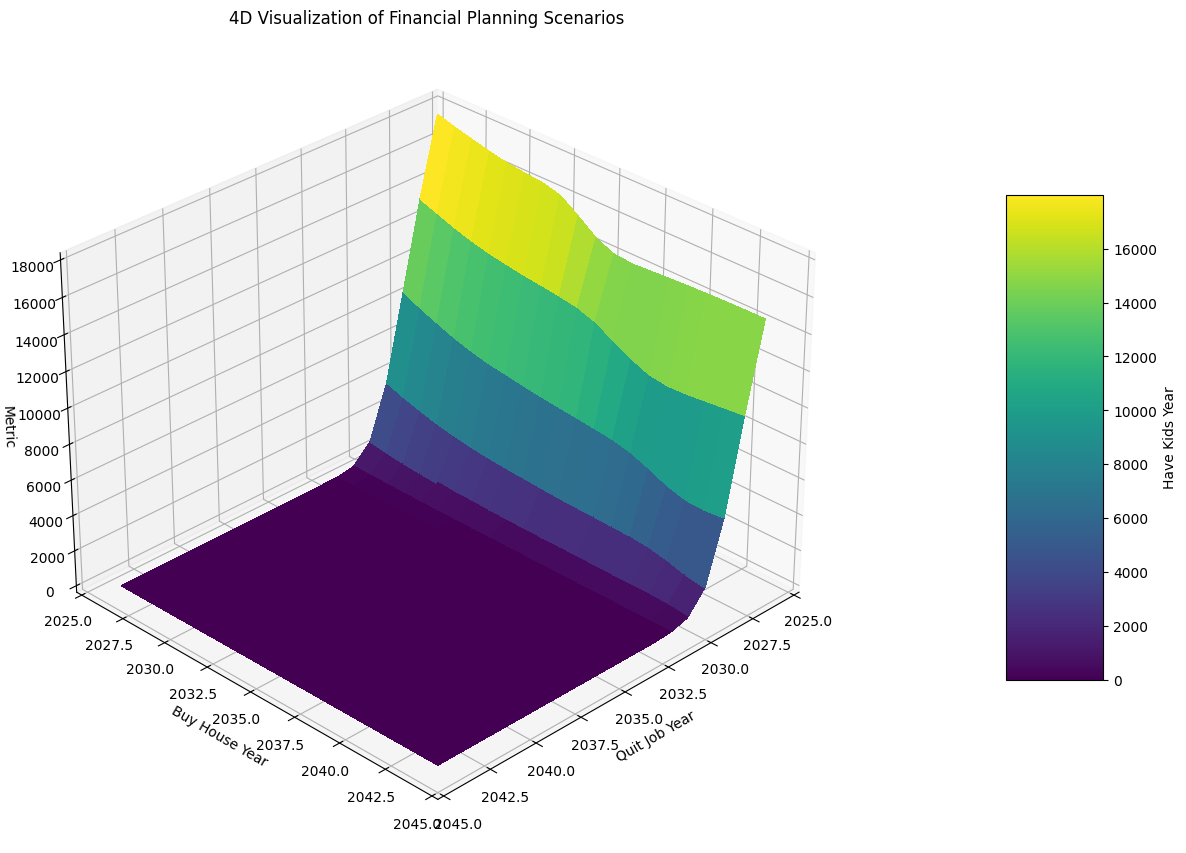

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create pivot tables for metric and have_kids_year
metric_pivot = results_df.pivot(index='buy_house_year', columns='quit_job_year', values='metric')
kids_pivot = results_df.pivot(index='buy_house_year', columns='quit_job_year', values='metric')

# Create a meshgrid for the x and y axes
X, Y = np.meshgrid(metric_pivot.columns, metric_pivot.index)

# Create the 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, metric_pivot.values, 
                       facecolors=plt.cm.viridis(kids_pivot.values/kids_pivot.values.max()),
                       rstride=1, cstride=1, antialiased=False, shade=False)

# Set labels and title
ax.set_xlabel('Quit Job Year')
ax.set_ylabel('Buy House Year')
ax.set_zlabel('Metric')
ax.set_title('4D Visualization of Financial Planning Scenarios')

kids_sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=kids_pivot.values.min(), vmax=kids_pivot.values.max()))
kids_sm.set_array([])
cbar_kids = fig.colorbar(kids_sm, ax=ax, shrink=0.5, aspect=5, pad=0.15, label='Have Kids Year')

# Improve the angle for better visibility
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()
